In [1]:
import os

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV


from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data_path = os.path.join('data', 'train.csv')
sub_data_path = os.path.join('data', 'test.csv')

In [3]:
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(df_train.shape))
print('sub data dim : {}'.format(df_test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

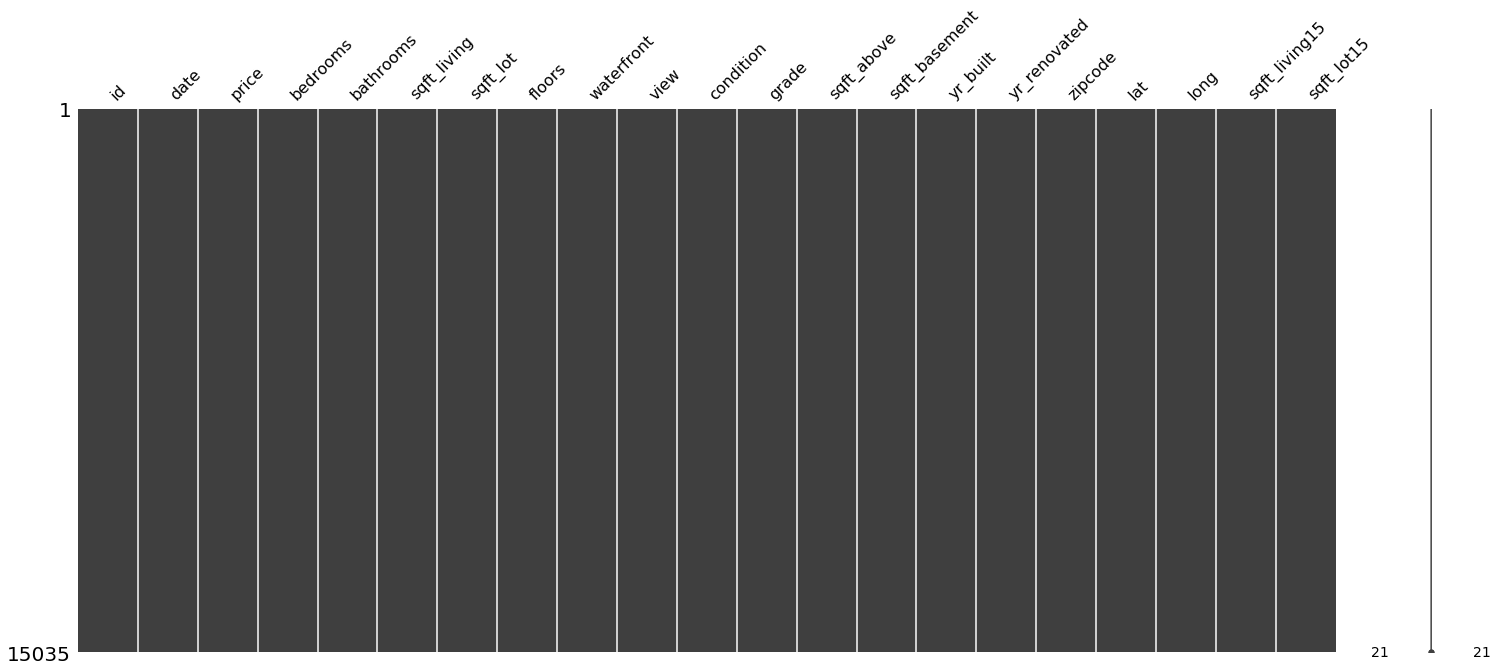

In [4]:
msno.matrix(df_train)

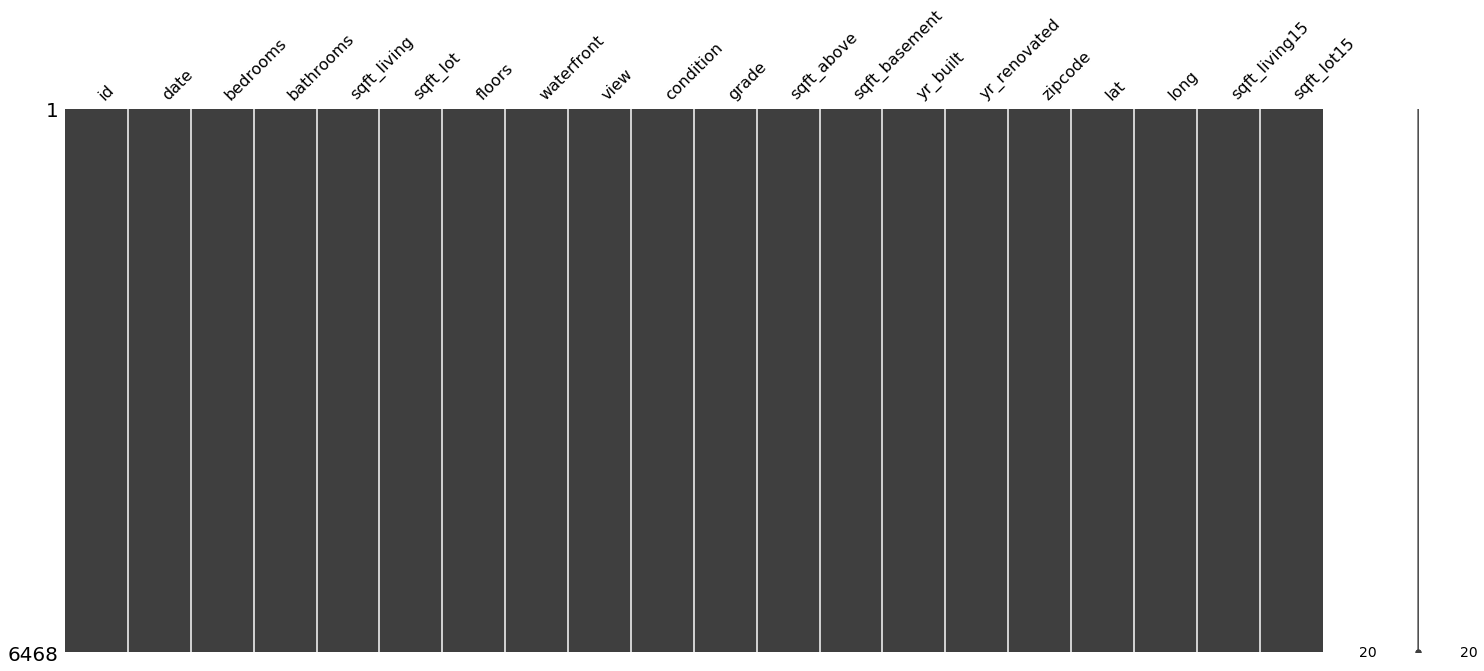

In [5]:
msno.matrix(df_test)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [6]:
for c in df_train.columns:
    print(f'{c:15} : {df_train[c].isnull().sum()}')

id              : 0
date            : 0
price           : 0
bedrooms        : 0
bathrooms       : 0
sqft_living     : 0
sqft_lot        : 0
floors          : 0
waterfront      : 0
view            : 0
condition       : 0
grade           : 0
sqft_above      : 0
sqft_basement   : 0
yr_built        : 0
yr_renovated    : 0
zipcode         : 0
lat             : 0
long            : 0
sqft_living15   : 0
sqft_lot15      : 0


In [7]:
for c in df_test.columns:
    print(f'{c:15} : {df_test[c].isnull().sum()}')

id              : 0
date            : 0
bedrooms        : 0
bathrooms       : 0
sqft_living     : 0
sqft_lot        : 0
floors          : 0
waterfront      : 0
view            : 0
condition       : 0
grade           : 0
sqft_above      : 0
sqft_basement   : 0
yr_built        : 0
yr_renovated    : 0
zipcode         : 0
lat             : 0
long            : 0
sqft_living15   : 0
sqft_lot15      : 0


* 결측치 없음

<hr>

In [8]:
df_train['date'] = df_train['date'].apply(lambda x: x[:6])

In [9]:
df_train['year'] = df_train['date'].apply(lambda x: int(x[:4]))
df_train['month'] = df_train['date'].apply(lambda x: int(x[4:6]))

In [10]:
df_train.drop(['date'],axis=1, inplace=True)

In [11]:
df_train.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,0,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10
1,1,180000.0,2,1.00,770,10000,1.0,0,0,3,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2
2,2,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2
3,3,257500.0,3,2.25,1715,6819,2.0,0,0,3,...,0,1995,0,98003,47.3097,-122.327,2238,6819,2014,6
4,4,291850.0,3,1.50,1060,9711,1.0,0,0,3,...,0,1963,0,98198,47.4095,-122.315,1650,9711,2015,1


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

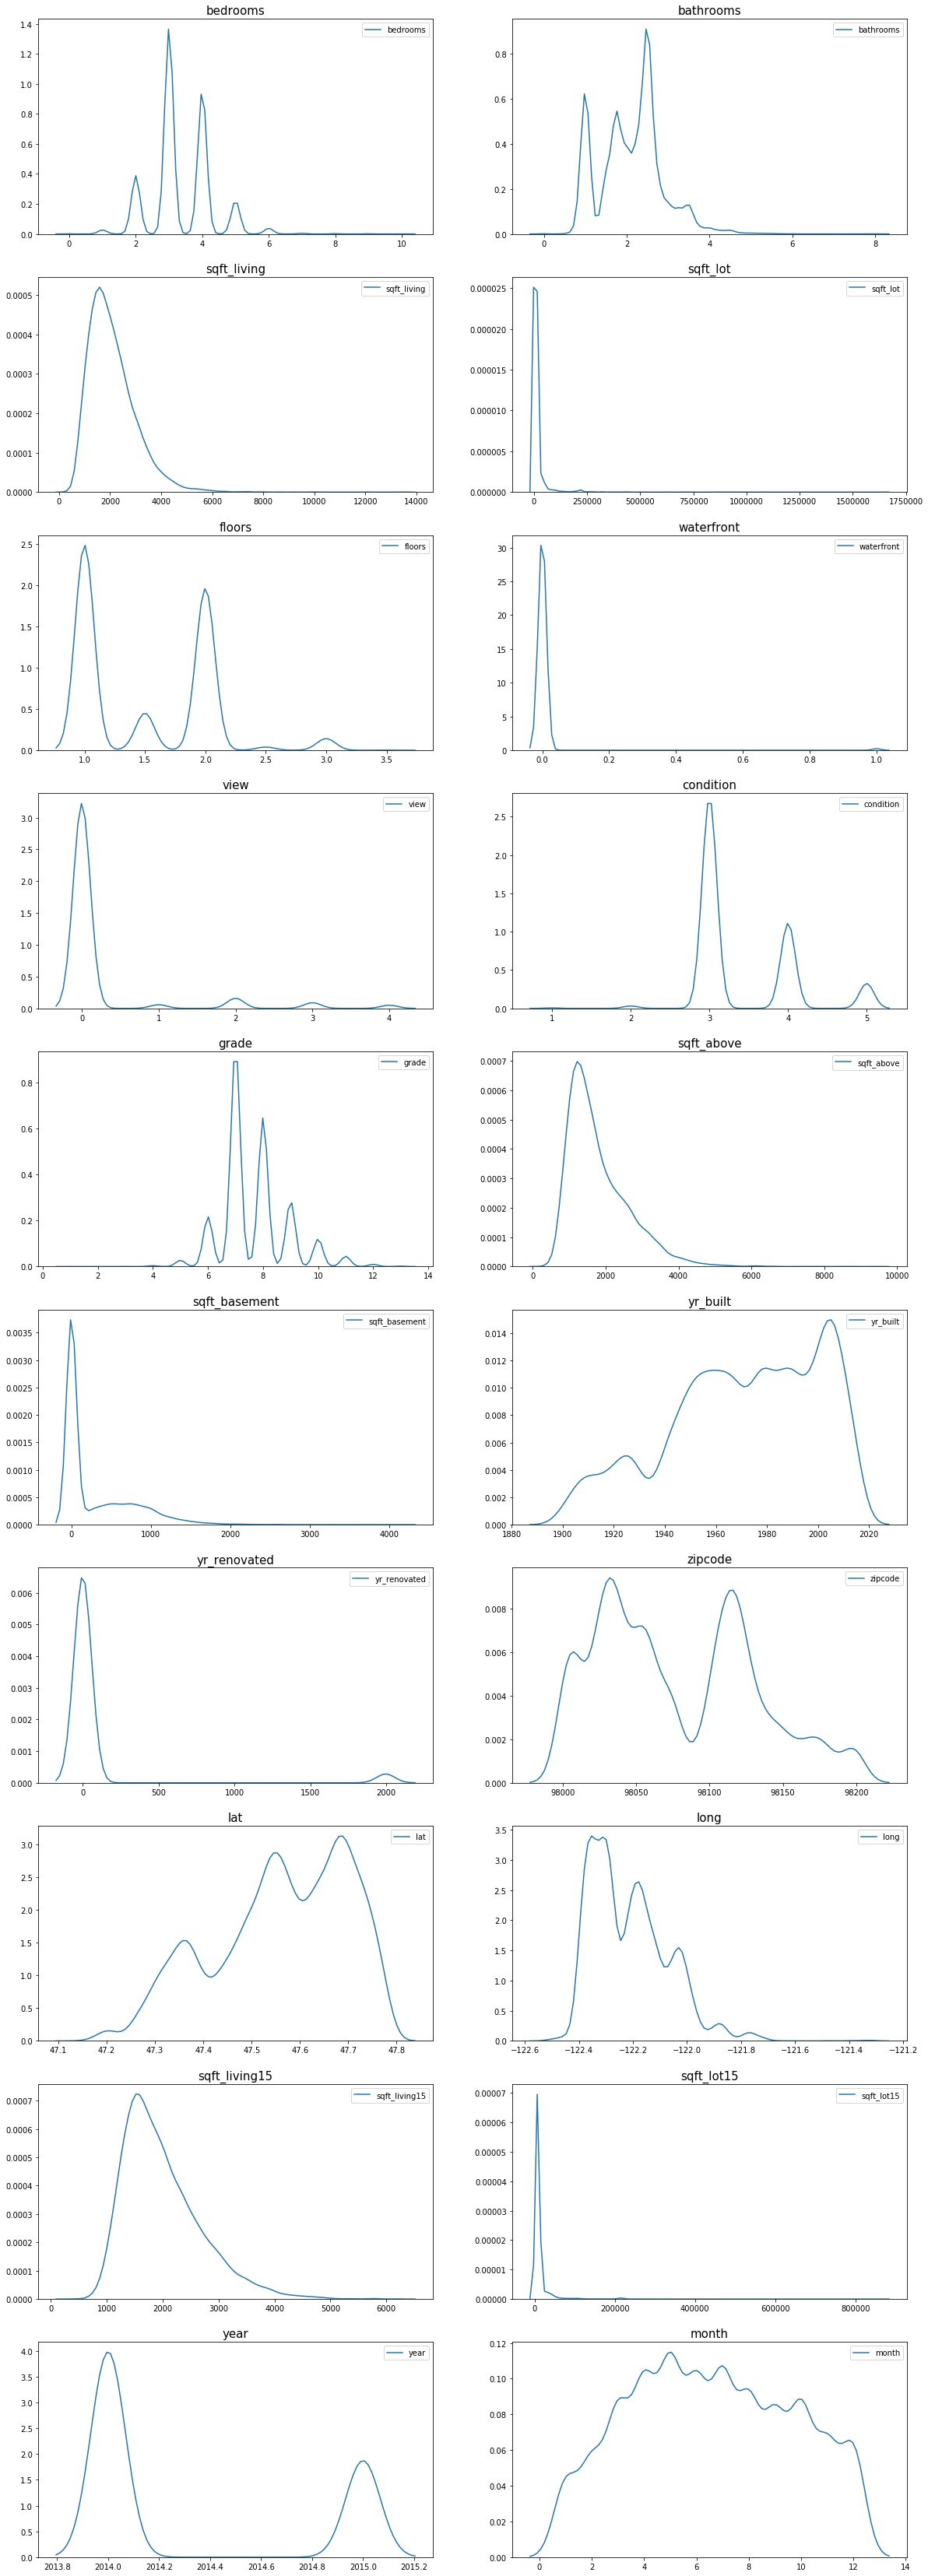

In [12]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
for idx, col in enumerate(df_train.columns[2:]):
    i, j = idx // 2, idx % 2
    sns.kdeplot(df_train[col],ax=ax[i][j])
    ax[i][j].set_title(col, fontsize=15)
    

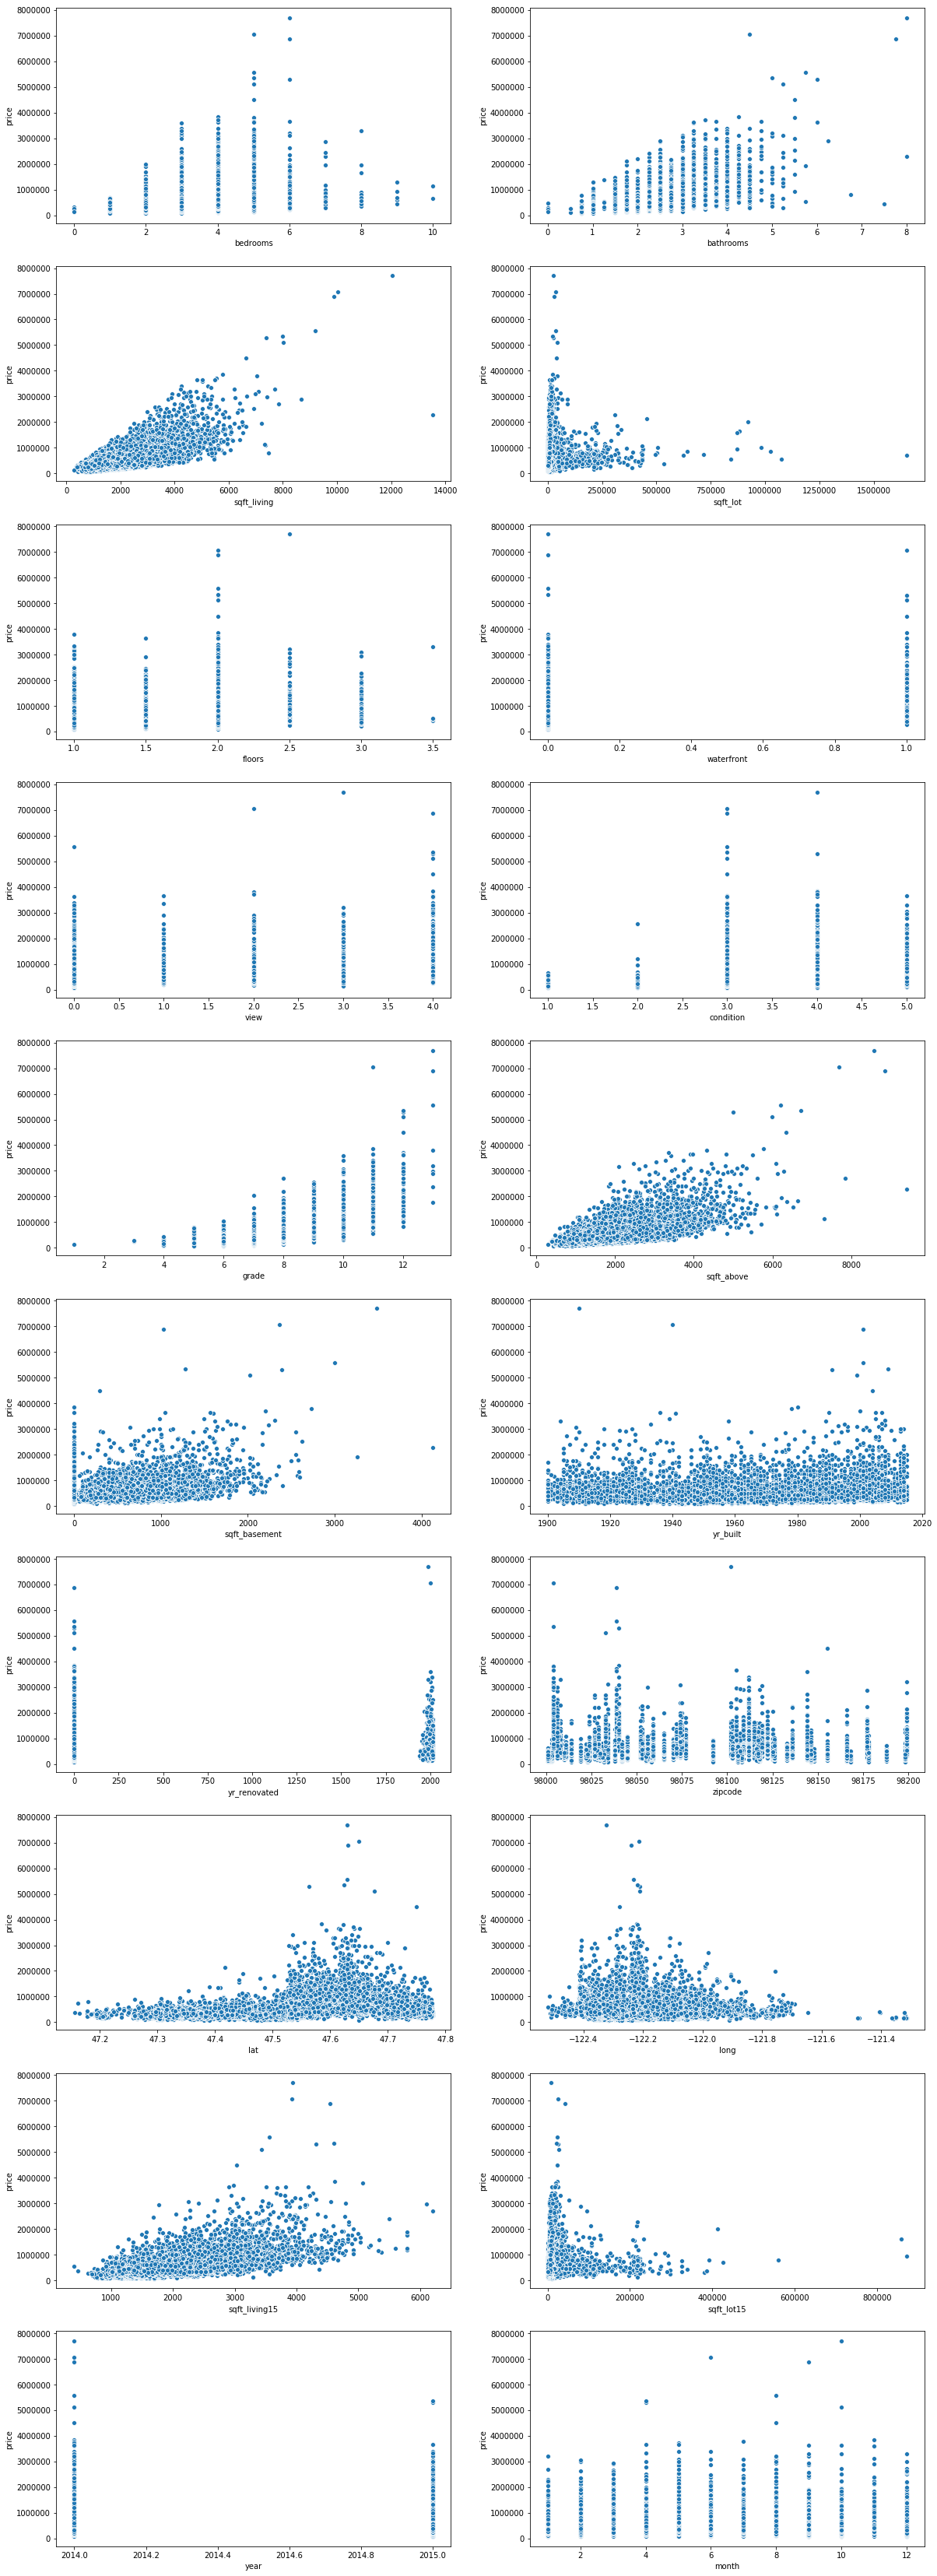

In [13]:
plt.close('all')
fig, ax = plt.subplots(10, 2, figsize=(20,60))
for idx, col in enumerate(df_train.columns[2:]):
    i, j = idx // 2, idx % 2
    
    sns.scatterplot(x=col, y='price', data=df_train, ax=ax[i][j])

* 주요 피쳐들: grade, sqft_*, bathrooms

c:\users\jmson\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


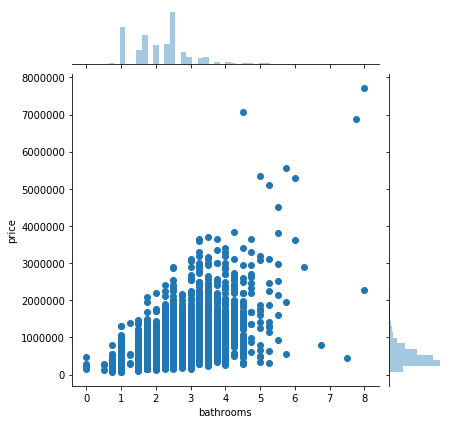

In [14]:
sns.jointplot(x='bathrooms',y='price', data=df_train)

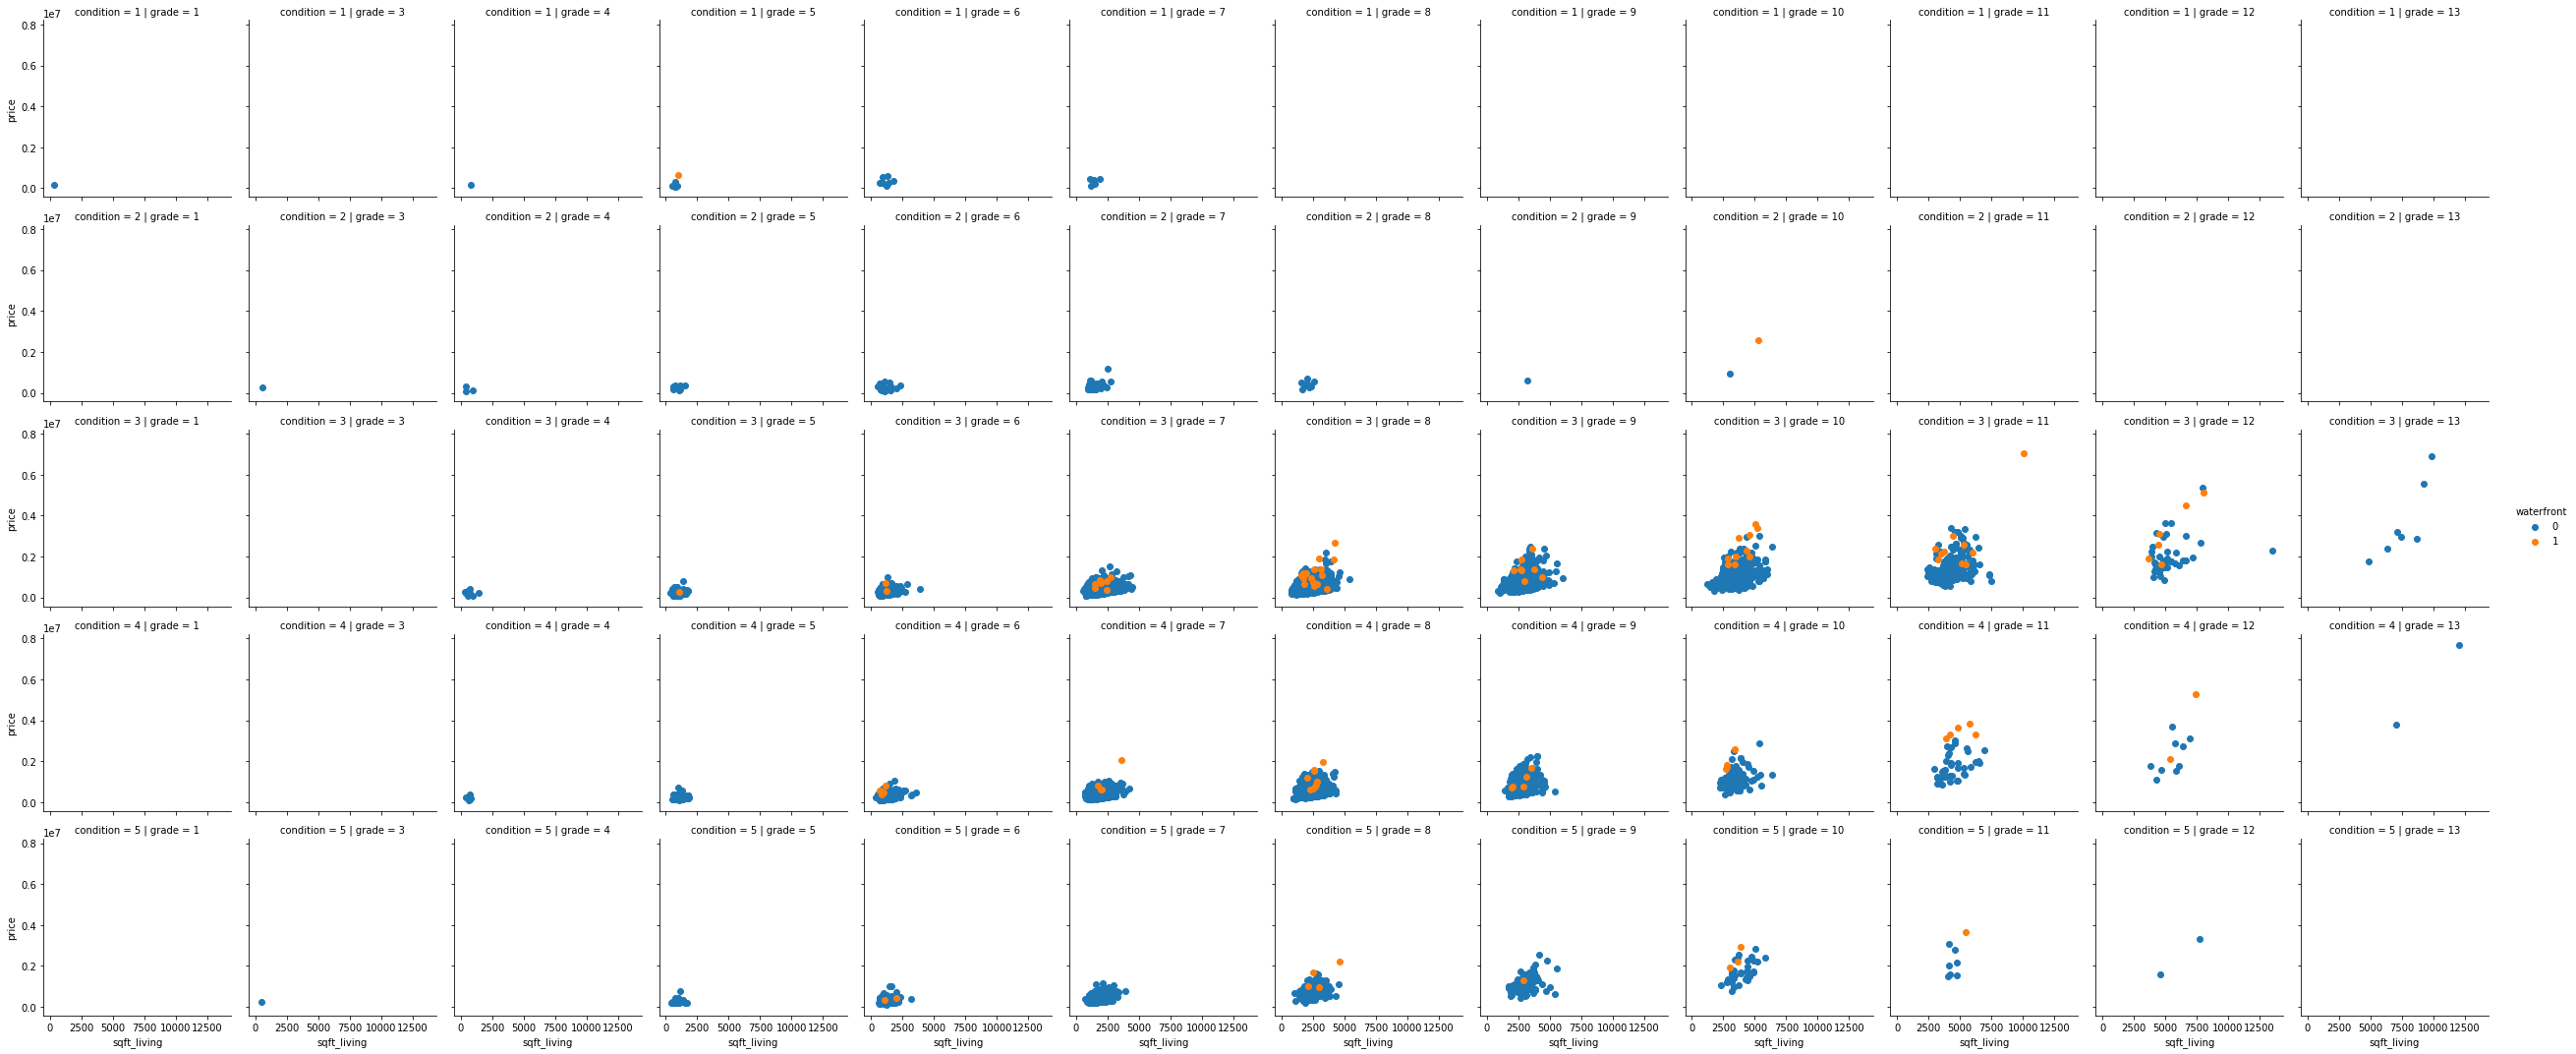

In [15]:
g = sns.FacetGrid(data=df_train, row="condition", col="grade", hue="waterfront")
g.map(plt.scatter,'sqft_living','price').add_legend()

In [16]:
df_train.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month'],
      dtype='object')

In [17]:
df_train['rooms'] = df_train['bedrooms']+df_train['bathrooms']

In [18]:
df_train['avg_room'] = df_train.sqft_above / (df_train.rooms+1)

In [19]:
df_train['sqft_inner_total'] = df_train.sqft_above+df_train.sqft_basement

In [20]:
df_train['sqft_total'] = df_train.sqft_inner_total + df_train.sqft_lot

In [21]:
lambda_fn = lambda row: row['year'] - row['yr_built'] + 2
df_train['age'] = df_train.apply(lambda_fn, axis=1)

In [22]:
df_train['lat'] = df_train['lat'].values - 47
df_train['long'] = df_train['long'].values + 123

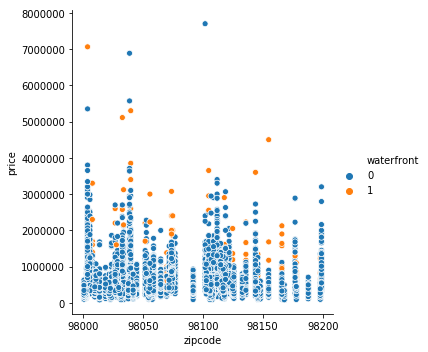

In [23]:
sns.relplot(x='zipcode', y='price', hue='waterfront', data=df_train)

In [24]:
zip_index = df_train.loc[df_train['waterfront']==1].groupby('zipcode').sum().index
df_train['mask_zipcode'] = df_train['zipcode'].apply(lambda x: 1 if x in zip_index else 0)

In [ ]:
df_train.head()

In [ ]:
df_train.columns

In [ ]:
fig, ax = plt.subplots(15, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
for idx, col in enumerate(df_train.columns[2:]):
    i, j = idx // 2, idx % 2
    sns.kdeplot(df_train[col],ax=ax[i][j])
    ax[i][j].set_title(col, fontsize=15)

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [ ]:
df_train.columns

In [ ]:
skew_columns = ['rooms','sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
               'lat','long','sqft_living15','sqft_lot15','sqft_inner_total',
                'sqft_total','sqft_total_origin','sqft_total_15','age']

def apply_log(x):
    if x < 1:
        x = abs(x)+1
    return np.log(x)

for col in skew_columns:
    df_train[col] = df_train[col].apply(apply_log)

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [ ]:
gboost = GradientBoostingRegressor(random_state=2019, max_depth=4, n_estimators=300)
xgboost = xgb.XGBRegressor(random_state=2019, max_depth=5, n_estimators=300)
lightgbm = lgb.LGBMRegressor(random_state=2019, max_depth=4, n_estimators=300)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [ ]:
from util import get_data

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures()

In [ ]:
X = df_train.drop(['id','price'], axis=1).values
y = df_train.price.values

In [ ]:
poly.fit(X)
X = poly.transform(X)

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [ ]:
def get_cv_score(models):
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], X, y)), 
                                             cv=5))

In [ ]:
get_cv_score(models)

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x) for m in models
    ])
    return np.mean(predictions, axis=1)

In [ ]:
y_pred = AveragingBlending(models, x, y, sub)

In [ ]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [ ]:
sub.to_csv('submission.csv', index=False)